# Loading the data-set - MSVD dataset

In [ ]:
!wget -nc https://www.cs.utexas.edu/users/ml/clamp/videoDescription/YouTubeClips.tar
!tar xf YouTubeClips.tar

In [ ]:
!wget -nc https://www.cs.utexas.edu/users/ml/clamp/videoDescription/AllVideoDescriptions.txt

--2022-05-01 20:45:25--  https://www.cs.utexas.edu/users/ml/clamp/videoDescription/AllVideoDescriptions.txt
Resolving www.cs.utexas.edu (www.cs.utexas.edu)... 128.83.120.48
Connecting to www.cs.utexas.edu (www.cs.utexas.edu)|128.83.120.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4277391 (4.1M) [text/plain]
Saving to: ‘AllVideoDescriptions.txt’

AllVideoDescription 100%[===================>]   4.08M   666KB/s    in 7.1s    

2022-05-01 20:45:33 (592 KB/s) - ‘AllVideoDescriptions.txt’ saved [4277391/4277391]



## The features that are extracted from video frames are saved and loaded here

In [ ]:
!wget -nc https://www.dropbox.com/s/1wrv7j6w8efeq5v/features_dir100.zip?dl=0
!unzip /content/features_dir100.zip?dl=0

Archive:  /content/features_dir100.zip?dl=0
  inflating: features_dir2/16iNk1hLJt4_37_40.npy  
  inflating: features_dir2/IhwPQL9dFYc_61_75.npy  
  inflating: features_dir2/mF6ijhSrbBQ_32_40.npy  
  inflating: features_dir2/-_hbPLsZvvo_18_25.npy  
  inflating: features_dir2/_WRC7HXBJpU_414_425.npy  
  inflating: features_dir2/_O9kWD8nuRU_25_35.npy  
  inflating: features_dir2/-vKO3uSG6Do_3_14.npy  
  inflating: features_dir2/Ea0thGZKPXA_25_35.npy  
  inflating: features_dir2/Kxa0mnDj0bs_113_124.npy  
  inflating: features_dir2/u9prcUCHlqM_73_80.npy  
  inflating: features_dir2/aHiUM8uWxxo_17_25.npy  
  inflating: features_dir2/giLxPCgLLqg_9_19.npy  
  inflating: features_dir2/qRoxNXm7INc_58_66.npy  
  inflating: features_dir2/lfGlDg47How_361_367.npy  
  inflating: features_dir2/O06WXS_XZN0_0_6.npy  
  inflating: features_dir2/zSPBC8EO6dY_122_126.npy  
  inflating: features_dir2/Lt1JijkvSKk_0_10.npy  
  inflating: features_dir2/c51L6ZxZGjQ_137_154.npy  
  inflating: features_dir2/Tied-t

In [ ]:
import os, sys
os.rename("/content/features_dir2","/content/features_dir")


## Importing the libraries

In [ ]:
import numpy as np
import os, sys
import pickle, functools, operator
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import joblib
from tensorflow.keras.utils import to_categorical
#from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
import json
import random
from keras.utils.vis_utils import plot_model
import tensorflow as tf
import datetime

## Data loading and pre-processing the data:

Every caption from the dataset is pre-processed by adding the $<bos>$ and $<eos>$ labels to mark the beginning and end of string respectively.

In [ ]:
with open('/content/AllVideoDescriptions.txt') as data_file:
    #y_data = json.load(data_file)
    contents = data_file.readlines()

In [ ]:
#Defining the split of data between training and validation
train_split=0.85

# Slicing the contents to make sure we are keeping only the video ID and the caption
co=contents[7:]
# a=co[0]
sc=[]
vocab_list=[]
# Adding <bos> and <eos> to caption strings
for i in co:
  # "cap" contains the caption
  cap=i.split(' ', 1)[1]
  # "lab" contains the videoID/label
  lab=i.split(' ', 1)[0]
  # pre-processing the caption
  cap = "<bos> " + cap + " <eos>"
  # Limiting the length of the caption to lie between 6 and 10 to maintain conistency
  if len(cap.split())>10 or len(cap.split())<6:
    continue
  else:
    sc.append([cap, lab])
train_list=sc
print(len(train_list))

training_list = train_list[:int(len(train_list)*train_split)]
validation_list = train_list[int(len(train_list)*train_split)+100:]
test = train_list[int(len(train_list)*train_split):int(len(train_list)*train_split)+100]
random.shuffle(training_list)
random.shuffle(validation_list)
for train in training_list:
    vocab_list.append(train[0])
# Tokenizing the words
tokenizer = Tokenizer(num_words=1500)
tokenizer.fit_on_texts(vocab_list)
print(len(tokenizer.word_index))
x_data = {}
#TRAIN_FEATURE_DIR = os.path.join('training_data', 'feat')
# Loading all the numpy arrays containing the extracted features and saving them in a dictionary
for filename in os.listdir('/content/features_dir'):
    features = np.load(os.path.join('/content/features_dir', filename))
    x_data[filename[:-4]] = features

print(len(training_list))
print(len(validation_list))
len(x_data)

60567
8539
51481
8986


1151

In [ ]:
rt=[]
for i in train_list:
  if i[1] in x_data.keys():
    rt.append([i[0],i[1]])
print(len(rt))

35165


In [ ]:
train_list=rt
l=len(train_list)
# Splitting the data among train, test and validation sets
training_list = train_list[:l]
test_list=train_list[l:l+100]
validation_list = train_list[l+100:]

In [ ]:
# Shuffling the data
random.shuffle(training_list)
random.shuffle(test_list)
random.shuffle(validation_list)

In [ ]:
tr_l=[]
tra_l=set()
for i in validation_list:
  tra_l.add(i[1])
c=0
for i in tra_l:
  c+=1
  tr_l.append(i)
  if(c==100):
    break


### The following code converts the videos to .npy format where the features from videos are extracted. The code is commented out because we have already loaded the extracted features in this notebook.

In [ ]:
#No need to run this as it takes a lot of time we will be using pre- existing which we have downloaded

# import shutil
# import tqdm
# import numpy as np
# import cv2
# import os
# from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.models import Model
# #from config import settings as CONFIG
# #import config


# def video_to_frames(video):
#     path = os.path.join('/content/gdrive/MyDrive', 'temporary_images')
#     if os.path.exists(path):
#         shutil.rmtree(path)
#     os.makedirs(path)
#     video_path = os.path.join('/content/gdrive/MyDrive/YouTubeClips', video)
#     count = 0
#     image_list = []
#     # Path to video file
#     cap = cv2.VideoCapture(video_path)
#     while cap.isOpened():
#         ret, frame = cap.read()
#         if ret is False:
#             break
#         cv2.imwrite(os.path.join('/content', 'temporary_images', 'frame%d.jpg' % count), frame)
#         image_list.append(os.path.join('/content', 'temporary_images', 'frame%d.jpg' % count))
#         count += 1

#     cap.release()
#     cv2.destroyAllWindows()
#     return image_list


# def model_cnn_load():
#     model = VGG16(weights="imagenet", include_top=True, input_shape=(224, 224, 3))
#     out = model.layers[-2].output
#     model_final = Model(inputs=model.input, outputs=out)
#     return model_final


# def load_image(path):
#     img = cv2.imread(path)
#     img = cv2.resize(img, (224, 224))
#     return img


# def extract_features(video, model):
#     """
#     :param video: The video whose frames are to be extracted to convert into a numpy array
#     :param model: the pretrained vgg16 model
#     :return: numpy array of size 4096x80
#     """
#     video_id = video.split(".")[0]
#     print(video_id)
#     print(f'Processing video {video}')

#     image_list = video_to_frames(video)
#     print(len(image_list))
#     if(len(image_list)==0):
#       return np.zeros((len(image_list), 224, 224, 3))
#     samples = np.round(np.linspace(0, len(image_list) - 1, 80))
#     image_list = [image_list[int(sample)] for sample in samples]
#     images = np.zeros((len(image_list), 224, 224, 3))
#     for i in range(len(image_list)):
#         img = load_image(image_list[i])
#         images[i] = img
#     images = np.array(images)
#     fc_feats = model.predict(images, batch_size=128)
#     img_feats = np.array(fc_feats)
#     # cleanup
#     shutil.rmtree(os.path.join('/content', 'temporary_images'))
#     return img_feats


# def extract_feats_pretrained_cnn():
#     """
#     saves the numpy features from all the videos
#     """
#     model = model_cnn_load()
#     print('Model loaded')

#     if not os.path.isdir(os.path.join('/content', 'feat')):
#         os.mkdir(os.path.join('/content', 'feat'))
#     if not os.path.isdir(os.path.join('/content', 'features_dir')):
#         os.mkdir(os.path.join('/content', 'features_dir'))
#     video_list = os.listdir(os.path.join('/content', 'YouTubeClips'))

#     for video in video_list:

#         outfile = os.path.join('/content', 'features_dir', video.split(".")[0] + '.npy')
#         img_feats = extract_features(video, model)
#         np.save(outfile, img_feats)


# if __name__ == "__main__":
#     extract_feats_pretrained_cnn()

##**Training the data**

In [ ]:
def load_datatest(train_path, epochs=100, x_data=x_data, tokenizer=tokenizer, num_decoder_tokens=1500,training_list=train_list, batch_size=320, maxlen=10):
    encoder_input_data = []
    decoder_input_data = []
    decoder_target_data = []
    videoId = []
    videoSeq = []
    # separating the videoId and the video captions
    for idx, cap in enumerate(training_list):
        caption = cap[0]
        videoId.append(cap[1])
        videoSeq.append(caption)
    # converting the captions to tokens and padding them to equal sizes
    train_sequences = tokenizer.texts_to_sequences(videoSeq)
    train_sequences = np.array(train_sequences)
    train_sequences = pad_sequences(train_sequences, padding='post',truncating='post', maxlen=maxlen)
    max_seq_length = train_sequences.shape[1]
    filesize = len(train_sequences)
    X_data = []
    y_data = []
    vCount = 0
    n = 0
    for i in range(epochs):
      for idx in  range(0,filesize):
        n += 1
        if videoId[idx] in x_data.keys():
          encoder_input_data.append(x_data[videoId[idx]])
          y = to_categorical(train_sequences[idx], num_decoder_tokens)
          decoder_input_data.append(y[:-1])
          decoder_target_data.append(y[1:])
          if n == batch_size:
            encoder_input = np.array(encoder_input_data)
            decoder_input = np.array(decoder_input_data)
            decoder_target = np.array(decoder_target_data)
            encoder_input_data = []
            decoder_input_data = []
            decoder_target_data = []
            n = 0
            yield ([encoder_input, decoder_input], decoder_target)

In [ ]:
train = load_datatest(train_path='training_data',batch_size=320, training_list=training_list, x_data=x_data, epochs=150)
valid = load_datatest(train_path='training_data',batch_size=320, training_list=validation_list, x_data=x_data, epochs=150)

In [ ]:
# defining the model parameters
time_steps_encoder=80
num_encoder_tokens=4096
latent_dim=512
time_steps_decoder=10
num_decoder_tokens=1500
batch_size=320

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 80, 4096)]   0           []                               
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 10, 1500)]   0           []                               
                                                                                                  
 endcoder_lstm (LSTM)           [(None, 80, 512),    9439232     ['encoder_inputs[0][0]']         
                                 (None, 512),                                                     
                                 (None, 512)]                                                     
                                                                                              

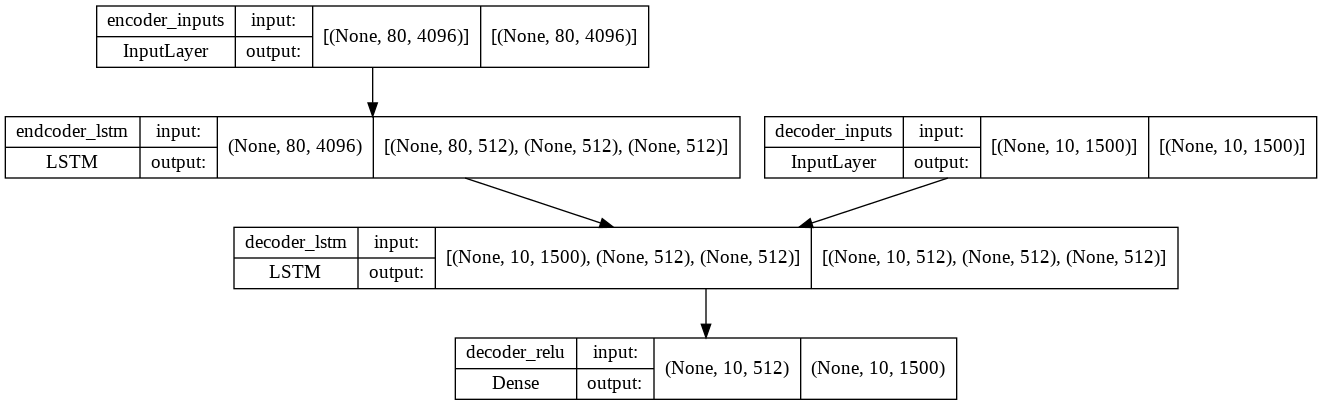

In [ ]:
# Setting up the encoder
encoder_inputs = Input(shape=(time_steps_encoder, num_encoder_tokens), name="encoder_inputs")
encoder = LSTM(latent_dim, return_state=True,return_sequences=True, name='endcoder_lstm')
_, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]


# Set up the decoder
decoder_inputs = Input(shape=(time_steps_decoder, num_decoder_tokens), name= "decoder_inputs")
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder_lstm')
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_relu')
decoder_outputs = decoder_dense(decoder_outputs)


model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()
plot_model(model, to_file='model_train.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Early Stopping -  to prevent overfitting
earlystopping = EarlyStopping(monitor='val_loss', patience = 5, verbose=1, mode='min')

# Tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Run training
opt = tf.keras.optimizers.Adam(learning_rate = 0.0003)
x = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1,patience=2,verbose=0,mode="auto")
model.compile(metrics=['accuracy'], optimizer=opt, loss='categorical_crossentropy')



model.fit(train, validation_data=valid, validation_steps=(len(validation_list)//batch_size),
        epochs=100, steps_per_epoch=(len(training_list)//batch_size),
            callbacks=[x, earlystopping, tensorboard_callback])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


Epoch 1/100
109/109 [==============================] - ETA: 0s - loss: 3.5091 - accuracy: 0.3991

StopIteration: ignored

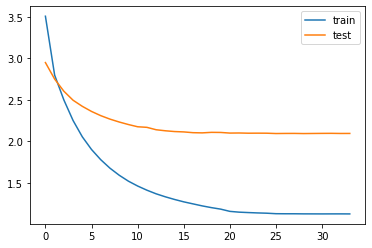

In [ ]:
import matplotlib.pyplot as plt
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig("loss.pdf")
plt.show()


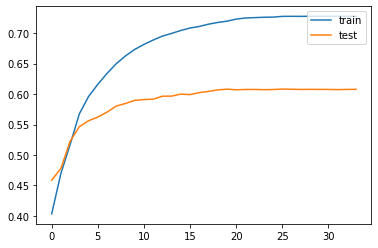

In [ ]:
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig("accuracy.pdf")
plt.show()

In [ ]:
x_test=[]
y_test=[]
for i in test_list:
  x_test.append(x_data[i[1]])
  y_test.append(i[0])

In [ ]:
test = load_datatest(train_path='training_data',batch_size=320, training_list=test_list, x_data=x_data, epochs=150)

In [ ]:
score, acc = model.evaluate(test,
                            batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


46/46 [==============================] - 11s 235ms/step - loss: 2.0870 - accuracy: 0.5866


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_inputs (InputLayer)  [(None, 80, 4096)]       0         
                                                                 
 endcoder_lstm (LSTM)        [(None, 80, 512),         9439232   
                              (None, 512),                       
                              (None, 512)]                       
                                                                 
Total params: 9,439,232
Trainable params: 9,439,232
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_inputs (InputLayer)    [(None, 10, 1500)]   0           []                               

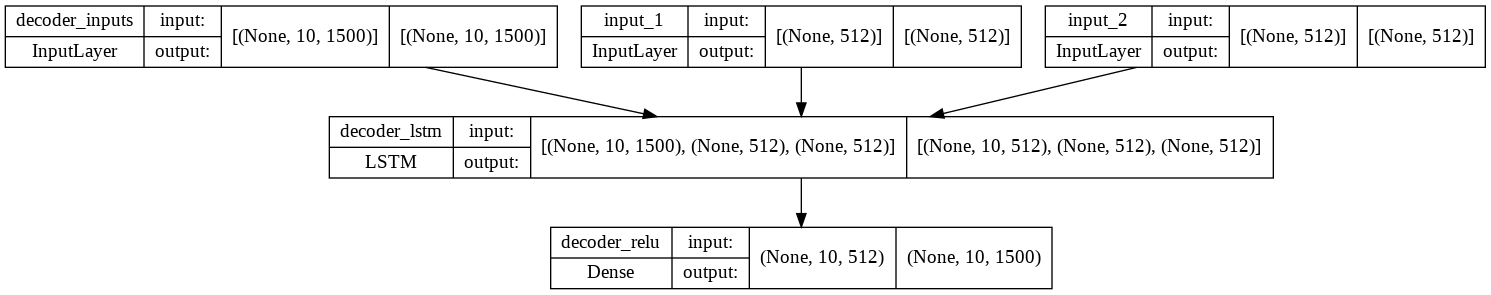

In [ ]:
save_model_path = 'model_final'
if not os.path.exists(save_model_path):
    os.makedirs(save_model_path)

# Saving encoder as in training
encoder_model = Model(encoder_inputs, encoder_states)

# Saving decoder states and dense layer
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)
encoder_model.summary()
decoder_model.summary()
encoder_model.save(os.path.join(save_model_path, 'encoder_model.h5'))
decoder_model.save_weights(os.path.join(save_model_path, 'decoder_model_weights.h5'))
with open(os.path.join(save_model_path,'tokenizer'+ str(num_decoder_tokens) ),'wb') as file:
    joblib.dump(tokenizer, file)
plot_model(encoder_model, to_file='model_inference_encoder.png', show_shapes=True, show_layer_names=True)
plot_model(decoder_model, to_file='model_inference_decoder.png', show_shapes=True, show_layer_names=True)

In [ ]:
L=[]
for i in tr_l:
  L.append(i+"\n")


In [ ]:
file1 = open("testing_id.txt","w")
file1.writelines(L)
file1.close()

### Predicting and storing the test data output

In [ ]:
# class to perform inference on all test files and save as test_output.txt

class Video2Text(object):
    ''' Initialize the parameters for the model '''
    def __init__(self):
        self.latent_dim = 512
        self.num_encoder_tokens = 4096
        self.num_decoder_tokens = 1500
        self.time_steps_encoder = 80
        self.time_steps_decoder = None
        self.preload = True
        self.preload_data_path = 'preload_data'
        self.max_probability = -1

        # processed data
        self.encoder_input_data = []
        self.decoder_input_data = []
        self.decoder_target_data = []
        self.tokenizer = None

        # models
        self.encoder_model = None
        self.decoder_model = None
        self.inf_encoder_model = None
        self.inf_decoder_model = None
        self.save_model_path = '/content/model_final'
        self.test_path = 'testing_data'
    def load_inference_models(self):
        # load tokenizer

        with open(os.path.join(self.save_model_path, 'tokenizer' + str(self.num_decoder_tokens)), 'rb') as file:
            self.tokenizer = joblib.load(file)

        # inference encoder model
        self.inf_encoder_model = load_model(os.path.join(self.save_model_path, 'encoder_model.h5'))

        # inference decoder model
        decoder_inputs = Input(shape=(None, self.num_decoder_tokens))
        decoder_dense = Dense(self.num_decoder_tokens, activation='softmax')
        decoder_lstm = LSTM(self.latent_dim, return_sequences=True, return_state=True)
        decoder_state_input_h = Input(shape=(self.latent_dim,))
        decoder_state_input_c = Input(shape=(self.latent_dim,))
        decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
        decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
        decoder_states = [state_h, state_c]
        decoder_outputs = decoder_dense(decoder_outputs)
        self.inf_decoder_model = Model(
            [decoder_inputs] + decoder_states_inputs,
            [decoder_outputs] + decoder_states)
        self.inf_decoder_model.load_weights(os.path.join(self.save_model_path, 'decoder_model_weights.h5'))

    def decode_sequence2bs(self, input_seq):
        states_value = self.inf_encoder_model.predict(input_seq)
        target_seq = np.zeros((1, 1, self.num_decoder_tokens))
        target_seq[0, 0, self.tokenizer.word_index['bos']] = 1
        self.beam_search(target_seq, states_value,[],[],0)
        return decode_seq

    def beam_search(self, target_seq, states_value, prob,  path, lens):
        global decode_seq
        node = 2
        output_tokens, h, c = self.inf_decoder_model.predict(
            [target_seq] + states_value)
        output_tokens = output_tokens.reshape((self.num_decoder_tokens))
        sampled_token_index = output_tokens.argsort()[-node:][::-1]
        states_value = [h, c]
        for i in range(node):
            if sampled_token_index[i] == 0:
                sampled_char = ''
            else:
                sampled_char = list(self.tokenizer.word_index.keys())[list(self.tokenizer.word_index.values()).index(sampled_token_index[i])]
            MAX_LEN = 10
            if(sampled_char != 'eos' and lens <= MAX_LEN):
                p = output_tokens[sampled_token_index[i]]
                if(sampled_char == ''):
                    p = 1
                prob_new = list(prob)
                prob_new.append(p)
                path_new = list(path)
                path_new.append(sampled_char)
                target_seq = np.zeros((1, 1, self.num_decoder_tokens))
                target_seq[0, 0, sampled_token_index[i]] = 1.
                self.beam_search(target_seq, states_value, prob_new, path_new, lens+1)
            else:
                p = output_tokens[sampled_token_index[i]]
                prob_new = list(prob)
                prob_new.append(p)
                p = functools.reduce(operator.mul, prob_new, 1)
                if(p > self.max_probability):
                    decode_seq = path
                    self.max_probability = p

    def decoded_sentence_tuning(self, decoded_sentence):
        decode_str = []
        filter_string = ['bos', 'eos']
        unigram = {}
        last_string = ""
        for idx2, c in enumerate(decoded_sentence):
            if c in unigram:
                unigram[c] += 1
            else:
                unigram[c] = 1
            if(last_string == c and idx2 > 0):
                continue
            if c in filter_string:
                continue
            if len(c) > 0:
                decode_str.append(c)
            if idx2 > 0:
                last_string = c
        return decode_str

    def get_test_data(self, path):
        X_test = []
        X_test_filename = []
        with open ('/content/testing_id.txt') as testing_file:
            lines = testing_file.readlines()
            for filename in lines:
                filename = filename.strip()
                f = np.load(os.path.join('/content/features_dir', filename + '.npy'))
                X_test.append(f)
                X_test_filename.append(filename[:-4])
            X_test = np.array(X_test)
        return X_test, X_test_filename

    def test(self):
        X_test, X_test_filename = self.get_test_data(os.path.join(self.test_path))
        print(len(X_test), len(X_test_filename))
        # generate inference test outputs
        #c1=0
        with open(os.path.join(self.save_model_path, 'test_output.txt'), 'w') as file:
            for idx, x in enumerate(X_test):
                file.write(X_test_filename[idx]+',')
                decoded_sentence = self.decode_sequence2bs(x.reshape(-1, 80, 4096))
                decode_str = self.decoded_sentence_tuning(decoded_sentence)
                for d in decode_str:
                    file.write(d + ' ')
                file.write('\n')
                #print(c1)
                #c1+=1
                # re-init max prob
                self.max_probability = -1

In [ ]:
c = Video2Text()
c.load_inference_models()
c.test()

100 100
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


### Performing model-evaluation metrics - BLEU, ROUGE, CIDEr

In [ ]:
!pip install rouge-score

In [ ]:
L1=[]
with open('/content/test_output.txt') as file:
    for line in file:
        a=line.split(',')
        L1.append(a[1])


In [ ]:
file1 = open("testing_test1000.txt","w")
file1.writelines(L1)
file1.close()

In [ ]:
dic={}
for i in co:
  cap=i.split(' ', 1)[1]
  lab=i.split(' ', 1)[0]
  dic[lab]=list()

In [ ]:
for i in co:
  cap=i.split(' ', 1)[1]
  lab=i.split(' ', 1)[0]
  dic[lab].append(cap)

In [ ]:
L1=[]
L2=[]
L3={}
with open('/content/test_output.txt') as file:
    for line in file:
        a=line.split(',')
        #print(c)
        # c=c+1
        #print(a)
        L3[a[0]]=a[1]
        L1.append(a[1])
        L2.append(a[0])

In [ ]:
dic2={}
for i in range(len(L2)):
  for key in dic:
    if key.startswith(L2[i]):
      dic2[key]=L3[L2[i]]
      break


In [ ]:
L10=[]
for key in dic2:
  L10.append(key+","+dic2[key])

In [ ]:
file1 = open("testing_test2000.txt","w")
file1.writelines(L10)
file1.close()

In [ ]:
L1=[]
L2=[]
L3={}
with open('/content/testing_test2000.txt') as file:
    for line in file:
        a=line.split(',')
        #print(c)
        # c=c+1
        #print(a)
        L3[a[0]]=[a[1]]
        L1.append(a[1])
        L2.append(a[0])

##**Evaluation of our model**

In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
!pip install "git+https://github.com/salaniz/pycocoevalcap.git"

  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-o4jq0gzu
  Running command git clone -q https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-o4jq0gzu
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312215 sha256=6cc03b5859a3adccf1d8ce081c770b6cc1a91ac5516d30460cc1faca9efd66d7
  Stored in directory: /tmp/pip-ephem-wheel-cache-vwfmuxs0/wheels/6f/c9/51/e266f0496048c16686e133d8e33644d692931a356bfb372aae
Successfully built pycocoevalcap


### Using Microsoft's COCO Evaluation on our dataset
Cited: https://github.com/tylin/coco-caption/blob/master/pycocoevalcap/eval.py

In [ ]:
from pycocoevalcap.tokenizer.ptbtokenizer import PTBTokenizer
from pycocoevalcap.bleu.bleu import Bleu
#from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider

In [ ]:
class COCOEvalCap:
    def __init__(self,images,gts,res):
        self.evalImgs = []
        self.eval = {}
        self.imgToEval = {}
        self.params = {'image_id': images}
        self.gts = gts
        self.res = res

    def evaluate(self):
        imgIds = self.params['image_id']
        gts = self.gts
        res = self.res
        print('tokenization...')
        # =================================================
        # Set up scorers
        # =================================================
        print('setting up scorers...')
        scorers = [
            (Bleu(4), ["Bleu_1", "Bleu_2", "Bleu_3", "Bleu_4"]),
            (Rouge(), "ROUGE_L"),
            (Cider(), "CIDEr")
        ]

        # =================================================
        # Compute scores
        # =================================================
        eval = {}
        for scorer, method in scorers:
            print('computing %s score...', scorer.method())
            score, scores = scorer.compute_score(gts, res)
            if type(method) == list:
                for sc, scs, m in zip(score, scores, method):
                    self.setEval(sc, m)
                    self.setImgToEvalImgs(scs, imgIds, m)
                    print(m, sc)
            else:
                self.setEval(score, method)
                self.setImgToEvalImgs(scores, imgIds, method)
                print(method, score)
        self.setEvalImgs()

    def setEval(self, score, method):
        self.eval[method] = score

    def setImgToEvalImgs(self, scores, imgIds, method):
        for imgId, score in zip(imgIds, scores):
            if not imgId in self.imgToEval:
                self.imgToEval[imgId] = {}
                self.imgToEval[imgId]["image_id"] = imgId
            self.imgToEval[imgId][method] = score

    def setEvalImgs(self):
        self.evalImgs = [eval for imgId, eval in self.imgToEval.items()]

def calculate_metrics(range_ids,datasetGTS,datasetRES):
    imgIds = range_ids
    evalObj = COCOEvalCap(imgIds,datasetGTS,datasetRES)
    evalObj.evaluate()
    return evalObj.eval

In [ ]:
# required_ids holds the reference captions for video IDs that are used for testing
required_ids = {}
for i in dic:
  if i in L3:
    required_ids[i] = dic[i]

In [ ]:
range_ids = required_ids.keys()
datasetGTS = required_ids   # references data
datasetRES = L3             # candidates data
print(calculate_metrics(range_ids,datasetGTS,datasetRES))

tokenization...
setting up scorers...
computing %s score... Bleu
{'testlen': 458, 'reflen': 465, 'guess': [458, 358, 258, 158], 'correct': [360, 195, 103, 34]}
ratio: 0.9849462365570216
%s: %0.3f Bleu_1 0.7741040402771091
%s: %0.3f Bleu_2 0.644401607541187
%s: %0.3f Bleu_3 0.5465514114005604
%s: %0.3f Bleu_4 0.4312899124968959
computing %s score... Rouge
%s: %0.3f ROUGE_L 0.5593199469566607
computing %s score... CIDEr
%s: %0.3f CIDEr 0.46373511290088254
{'Bleu_1': 0.7741040402771091, 'Bleu_2': 0.644401607541187, 'Bleu_3': 0.5465514114005604, 'Bleu_4': 0.4312899124968959, 'ROUGE_L': 0.5593199469566607, 'CIDEr': 0.46373511290088254}
